In [1]:
# For importing our data
from zipfile import ZipFile

# Data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic regression
from statsmodels.tools import tools
from statsmodels.api import Logit

from sklearn.metrics import roc_curve

In [2]:
# Original weather data needed the weather condition to be decoded
# Done using https://gist.github.com/kfish610/29d0e2874824732ec2d2922f979e4acb
# Due to slowness saved as a csv

# Further minimized using https://gist.github.com/kfish610/48605253428c856bbb1f461c10b6d6ac 

In [3]:
# The original ASPM data (ASPM.zip) contains the hourly count of departures, as well as the percentage of delays
# We have to expand this into individual flights for the logistic regression
# Because we don't have the original flight data, we only have precision down to the hour
# Done using https://gist.github.com/kfish610/b63bbf488d91dcf6877925f7ddfe618b
# This also merges the weather data with the ASPM data, which in Python is too memory inefficient

zipFile = ZipFile('data/ASPM_Transformed.zip')

# Load, but also exclude COVID data
# This also excludes hail, as there are only 41 instances of hail in the whole dataset
df = pd.concat([
        pd.concat(pd.read_csv(
            zipFile.open(f"ASPM{year}.csv"), 
            chunksize=10000,
            usecols=range(1, 9)
        )) for year in range(2015, 2020)
    ])

# Lowercase for consistency
df.columns = df.columns.str.lower()

# Convert to category to save memory
df['facility'] = df['facility'].astype('category')

print(f"{df.shape}")
df.head()

(30081635, 8)


,facility,delayed,air_temp,wind_speed,precipitation,visibility,thunder,snow
0,BOS,0,1.0,4.63,0.0,10.0,0,0
1,FLL,1,22.0,4.63,0.0,10.0,0,0
2,IAD,0,1.0,0.00,0.0,10.0,0,0
3,JFK,0,2.0,2.06,0.0,10.0,0,0
4,JFK,0,2.0,2.06,0.0,10.0,0,0


In [4]:
endog = df.delayed
exog = tools.add_constant(df.iloc[:, 2:], prepend=True)
full_model = Logit(endog, exog).fit(disp=False)
print(full_model.summary())

                           Logit Regression Results                           
Dep. Variable:                delayed   No. Observations:             30081635
Model:                          Logit   Df Residuals:                 30081628
Method:                           MLE   Df Model:                            6
Date:                Sat, 10 Jun 2023   Pseudo R-squ.:                 0.01315
Time:                        20:29:05   Log-Likelihood:            -1.7677e+07
converged:                       True   LL-Null:                   -1.7912e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5567      0.002   -291.502      0.000      -0.560      -0.553
air_temp          0.0009   4.09e-05     20.995      0.000       0.001       0.001
wind_speed        0.0590      0.000    3

In [5]:
# sklearn's confusion matrix taxes 10x longer than this...
def confusion_matrix(y_true, y_pred):
    # Get all values that belong in a category
    def get_category(cat):
        return (y_true == cat[0]) & (y_pred == cat[1])
    
    # The four categories (first coordinate is true, second is predicted)
    categories = [(0, 0), (0, 1), (1, 0), (1, 1)]
    return np.apply_along_axis(get_category, arr=categories, axis=1).sum(axis=1).reshape(2, 2)

In [6]:
# tpr also known as recall
# ppv also known as precision
def classification_scores(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (tn + fp)
    tpr = tp / (tp + fn)
    ppv = tp / (tp + fp)
    f1_score = 2 * (ppv * tpr) / (ppv + tpr)
    return (fpr, tpr, ppv, f1_score)

In [7]:
thresholds = np.arange(0, 1, 0.05)
scores = np.empty((len(thresholds), 4))

for i, thresh in enumerate(thresholds):
    y_pred = np.where(full_model.predict() > thresh, 1, 0)
    scores[i] = classification_scores(df.delayed, y_pred)

Text(0, 0.5, 'True Positive Rate')

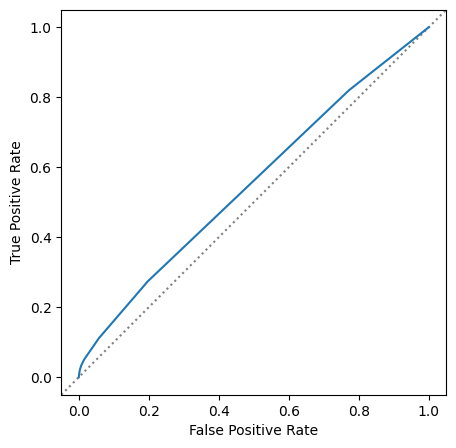

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(x=scores[:, 0], y=scores[:, 1])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]

ax.plot(lims, lims, 'k:', alpha=0.5, zorder=0)
ax.set_aspect('equal', 'box')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

Text(0, 0.5, 'Facility')

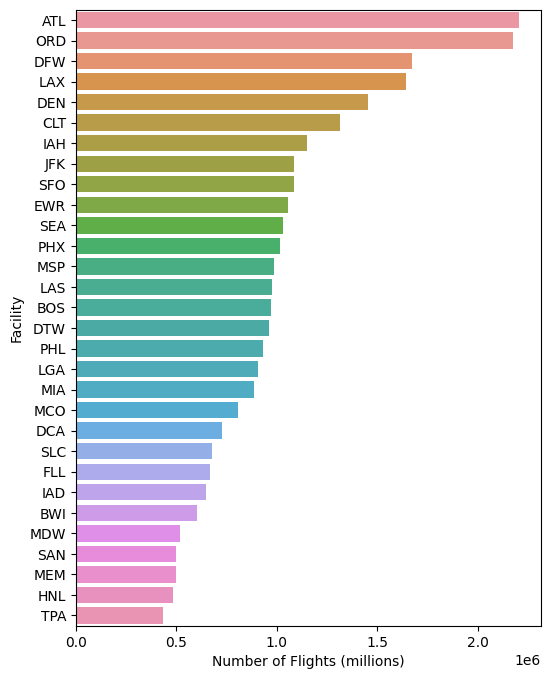

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
sns.countplot(y='facility', data=df, order=df.facility.value_counts().index)
ax.set_xlabel('Number of Flights (millions)')
ax.set_ylabel('Airport')
ax.set_title('Number of Flights by Airport (2015-2019)')

Text(0.5, 1.0, 'Percent Delayed by Airport (2015-2019)')

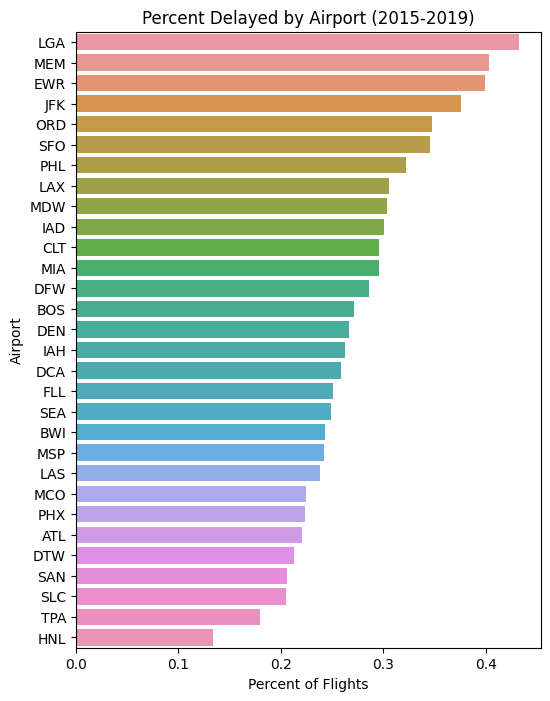

In [55]:
delayRates = df.facility[df.delayed == 1].value_counts() / df.facility.value_counts()

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
sns.barplot(y='facility', x='count', data=pd.DataFrame(delayRates).reset_index(), order=delayRates.sort_values(ascending=False).index)
ax.set_xlabel('Percent of Flights')
ax.set_ylabel('Airport')
ax.set_title('Percent Delayed by Airport (2015-2019)')